## Submitted by Yatharth Vardan
## Assignment 4

# Long Short Term Memory Networks for IoT Prediction

RNNs and LSTM models are very popular neural network architectures when working with sequential data, since they both carry some "memory" of previous inputs when predicting the next output. In this assignment we will continue to work with the Household Electricity Consumption dataset and use an LSTM model to predict the Global Active Power (GAP) from a sequence of previous GAP readings. You will build one model following the directions in this notebook closely, then you will be asked to make changes to that original model and analyze the effects that they had on the model performance. You will also be asked to compare the performance of your LSTM model to the linear regression predictor that you built in last week's assignment.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 

In [1]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'


import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.utils import pad_sequences

/Users/yatharthvardan/miniconda3/envs/tf-seg/lib/python3.10/site-packages/google/api_core/_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.19) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


In [ ]:
#use this cell to import additional libraries or define helper functions

## Load and prepare your data

We'll once again be using the cleaned household electricity consumption data from the previous two assignments. I recommend saving your dataset by running df.to_csv("filename") at the end of assignment 2 so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

Unlike when using Linear Regression to make our predictions for Global Active Power (GAP), LSTM requires that we have a pre-trained model when our predictive software is shipped (the ability to iterate on the model after it's put into production is another question for another day). Thus, we will train the model on a segment of our data and then measure its performance on simulated streaming data another segment of the data. Our dataset is very large, so for speed's sake, we will limit ourselves to 1% of the entire dataset.

**TODO: Import your data, select the a random 1% of the dataset, and then split it 80/20 into training and validation sets (the test split will come from the training data as part of the tensorflow LSTM model call). HINT: Think carefully about how you do your train/validation split--does it make sense to randomize the data?**

In [2]:
df = pd.read_csv('data.txt', sep=';')
#Load your data into a pandas dataframe here

/var/folders/wc/3m1jp8cj4f7fy8sfc6278n_c0000gn/T/ipykernel_99005/3203197234.py:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data.txt', sep=';')


In [3]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')

In [4]:
#create your training and validation sets here
from sklearn.model_selection import train_test_split


#assign size for data subset
total_size = len(df)
subset_size = int(total_size/100)

print(f"total size -> {total_size}")
print(f"1% size -> {subset_size}")
#take random data subset
random_sample = df[:subset_size]

#split data subset 80/20 for train/validation


train_size= int(subset_size*80/100)
print(f"Training size -> {train_size}")
print(f"Validation size -> {subset_size-train_size}")


cols_to_convert = df.columns.to_list()
cols_to_convert.remove('Date')
cols_to_convert.remove('Time')
cols_to_convert.remove('Sub_metering_3')


for col in cols_to_convert:
    random_sample[col] = pd.to_numeric(random_sample[col], errors='coerce').astype(float)

random_sample = random_sample.replace('?',np.nan)

random_sample[cols_to_convert] = imputer.fit_transform(random_sample[cols_to_convert])

total size -> 2075259
1% size -> 20752
Training size -> 16601
Validation size -> 4151


/var/folders/wc/3m1jp8cj4f7fy8sfc6278n_c0000gn/T/ipykernel_99005/3106589786.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  random_sample[col] = pd.to_numeric(random_sample[col], errors='coerce').astype(float)
/var/folders/wc/3m1jp8cj4f7fy8sfc6278n_c0000gn/T/ipykernel_99005/3106589786.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  random_sample[col] = pd.to_numeric(random_sample[col], errors='coerce').astype(float)
/var/folders/wc/3m1jp8cj4f7fy8sfc6278n_c0000gn/T/ipykernel_99005/3106589786.py:29:

In [5]:
train_df = random_sample[:train_size]
val_df = random_sample[train_size:]

In [6]:
#reset the indices for cleanliness
train_df = train_df.reset_index()
val_df = val_df.reset_index()

In [7]:
train_df.head()

,index,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [8]:
val_df.head()

,index,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16601,28/12/2006,06:05:00,0.352,0.220,249.38,1.6,0.0,0.0,0.0
1,16602,28/12/2006,06:06:00,0.348,0.216,248.79,1.6,0.0,0.0,0.0
2,16603,28/12/2006,06:07:00,0.346,0.214,248.52,1.6,0.0,0.0,0.0
3,16604,28/12/2006,06:08:00,0.340,0.204,246.98,1.6,0.0,0.0,0.0
4,16605,28/12/2006,06:09:00,0.338,0.200,246.39,1.6,0.0,0.0,0.0


Next we need to create our input and output sequences. In the lab session this week, we used an LSTM model to make a binary prediction, but LSTM models are very flexible in what they can output: we can also use them to predict a single real-numbered output (we can even use them to predict a sequence of outputs). Here we will train a model to predict a single real-numbered output such that we can compare our model directly to the linear regression model from last week.

**TODO: Create a nested list structure for the training data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output**

In [9]:
seq_arrays = []
seq_labs = []

In [10]:
# we'll start out with a 30 minute input sequence and a 5 minute predictive horizon
# we don't need to work in seconds this time, since we'll just use the indices instead of a unix timestamp
seq_length = 30
ph = 5

feat_cols = ['Global_active_power']

#create list of sequence length GAP readings
for i in range(len(train_df) - seq_length - ph):
    # Input: sequence of GAP measurements from index i to i+seq_length
    seq = train_df[feat_cols].values[i : i + seq_length]
    seq_arrays.append(seq)
    
    # Output: GAP measurement at the predictive horizon (seq_length + ph steps from start)
    label = train_df['Global_active_power'].values[i + seq_length + ph - 1]
    seq_labs.append(label)


#convert to numpy arrays and floats to appease keras/tensorflow        
seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [11]:
assert(seq_arrays.shape == (len(train_df)-seq_length-ph,seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph,))

In [12]:
seq_arrays.shape

(16566, 30, 1)

In [13]:
seq_labs.shape

(16566,)

**Q: What is the function of the assert statements in the above cell? Why do we use assertions in our code?**

A: Assert statements confirm that the shape of the seq_arraus is as expected, it will throw an error if the shape is different

## Model Training

We will begin with a model architecture very similar to the model we built in the lab session. We will have two LSTM layers, with 5 and 3 hidden units respectively, and we will apply dropout after each LSTM layer. However, we will use a LINEAR final layer and MSE for our loss function, since our output is continuous instead of binary.

**TODO: Fill in all values marked with a ?? in the cell below**

In [14]:
# define path to save model
model_path = 'LSTM_model2.keras'

# build the network
nb_features = seq_arrays.shape[2]
nb_out =1

In [15]:
nb_features

1

In [ ]:


model = Sequential()

#add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=100, # number of hidden units 
         return_sequences=True))
model.add(Dropout(0.2)) 

# add second LSTM layer
model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation('linear'))
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

print(model.summary())

# fit the network
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

/Users/yatharthvardan/miniconda3/envs/tf-seg/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
32/32 - 4s - 128ms/step - loss: 1.0340 - mse: 1.0340 - val_loss: 0.0821 - val_mse: 0.0821
Epoch 2/100
32/32 - 4s - 110ms/step - loss: 0.5562 - mse: 0.5562 - val_loss: 0.0861 - val_mse: 0.0861
Epoch 3/100
32/32 - 4s - 114ms/step - loss: 0.5464 - mse: 0.5464 - val_loss: 0.0846 - val_mse: 0.0846
Epoch 4/100
32/32 - 3s - 108ms/step - loss: 0.5386 - mse: 0.5386 - val_loss: 0.0841 - val_mse: 0.0841
Epoch 5/100
32/32 - 4s - 120ms/step - loss: 0.5328 - mse: 0.5328 - val_loss: 0.0866 - val_mse: 0.0866
Epoch 6/100
32/32 - 4s - 123ms/step - loss: 0.5404 - mse: 0.5404 - val_loss: 0.0828 - val_mse: 0.0828
Epoch 7/100
32/32 - 4s - 120ms/step - loss: 0.5348 - mse: 0.5348 - val_loss: 0.0802 - val_mse: 0.0802
Epoch 8/100
32/32 - 4s - 113ms/step - loss: 0.5210 - mse: 0.5210 - val_loss: 0.0815 - val_mse: 0.0815
Epoch 9/100
32/32 - 4s - 112ms/step - loss: 0.5188 - mse: 0.5188 - val_loss: 0.0823 - val_mse: 0.0823
Epoch 10/100
32/32 - 4s - 114ms/step - loss: 0.5169 - mse: 0.5169 - val_loss:

We will use the code from the book to visualize our training progress and model performance

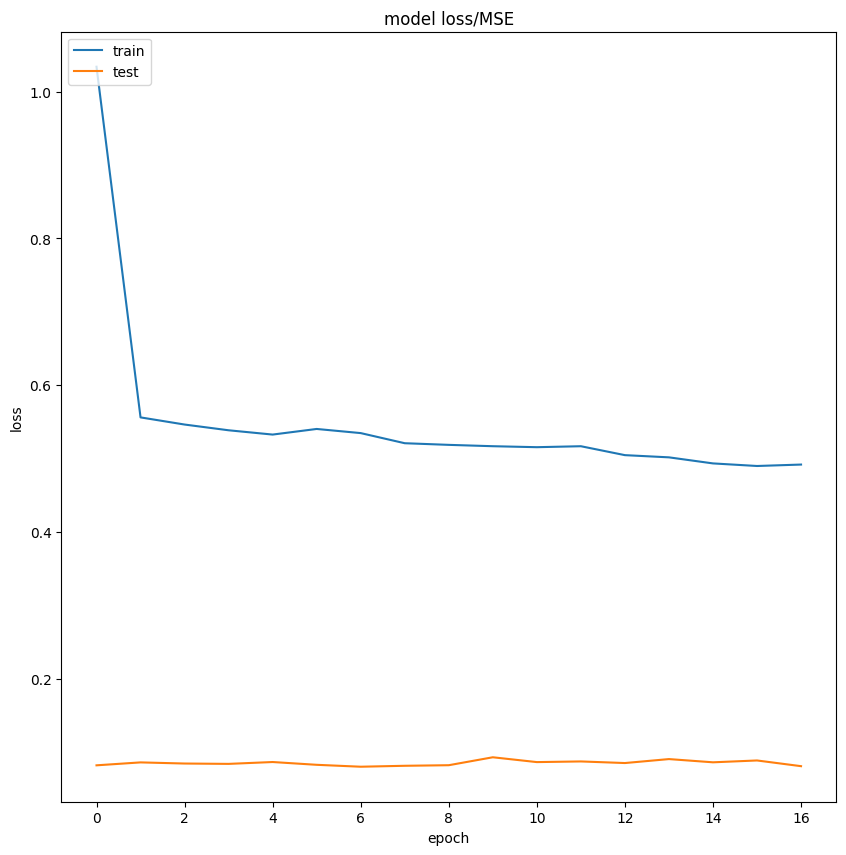

In [17]:
# summarize history for Loss/MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss/MSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")


## Validating our model

Now we need to create our simulated streaming validation set to test our model "in production". With our linear regression models, we were able to begin making predictions with only two datapoints, but the LSTM model requires an input sequence of *seq_length* to make a prediction. We can get around this limitation by "padding" our inputs when they are too short.

**TODO: create a nested list structure for the validation data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output. Begin your predictions after only two GAP measurements are available, and check out [this keras function](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) to automatically pad sequences that are too short.**

**Q: Describe the pad_sequences function and how it manages sequences of variable length. What does the "padding" argument determine, and which setting makes the most sense for our use case here?**

A: Pad sequences function is used to pad the incoming vector to match the input size of the model or a custom boundary. padding argument determines where the value will be adjusted to make the vector equal to the desired length , Pre - the padding values will happen as a prefix, however Post - the values will be padded as a suffux.

In [1]:
from keras.utils import pad_sequences

In [20]:
val_arrays = []
val_labs = []

#create list of GAP readings starting with a minimum of two readings
for i in range(len(val_df) - seq_length - ph):
    # Input: sequence of GAP measurements from index i to i+seq_length
    val = val_df[feat_cols].values[i : i + seq_length]
    val_arrays.append(val)
    
    # Output: GAP measurement at the predictive horizon (seq_length + ph steps from start)
    label = val_df['Global_active_power'].values[i + seq_length + ph - 1]
    val_labs.append(label)



In [21]:
# use the pad_sequences function on your input sequences
# remember that we will later want our datatype to be np.float32 
val_arrays = pad_sequences(val_arrays)        
#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

We will now run this validation data through our LSTM model and visualize its performance like we did on the linear regression data.

129/129 - 1s - 4ms/step - loss: 0.9156 - mse: 0.9156

MSE: 0.9155749082565308
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


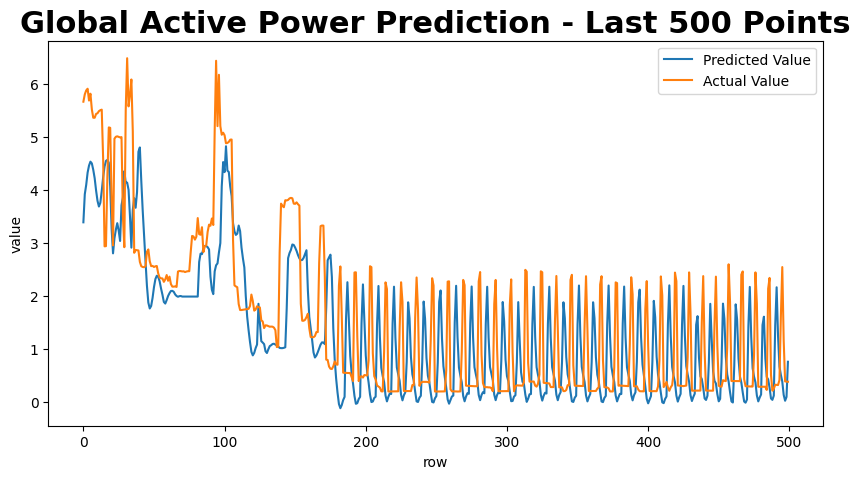

In [22]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 500 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

**Q: How did your model perform? What can you tell about the model from the loss curves? What could we do to try to improve the model?**

A: The model performed well, as visible from the raph plotted above, the model is able to predict the trend of the values along with the ability to predict minima and maxima in the trends. 

Based on your training plot, here are 4 key points to interpret these results for your assignment:

- Unusual "Test < Train" Gap: It is highly unusual for the Test Loss (0.08) to be significantly lower than the Train Loss (0.5). This typically indicates that your training data contains a lot of "noise" or complex variations that the model is struggling to learn, while the test set is much "cleaner" or easier to predict.
- Immediate Convergence: The model performs almost all of its learning in the very first epoch (the sharp drop from 1.0 to 0.55). After that, the training curve enters a plateau. This suggests that the model quickly found the most obvious patterns in your IoT data but is unable to refine its accuracy much further with its current architecture.
- High Stability (No Overfitting): There is absolutely no sign of overfitting. Overfitting would cause the orange line to start rising as the blue line falls. Because the test loss remains perfectly flat and low, the model is generalizing its (limited) knowledge very well across the entire training process.




## Model Optimization

Now it's your turn to build an LSTM-based model in hopes of improving performance on this training set. Changes that you might consider include:

- Add more variables to the input sequences
- Change the optimizer and/or adjust the learning rate
- Change the sequence length and/or the predictive horizon
- Change the number of hidden layers in each of the LSTM layers
- Change the model architecture altogether--think about adding convolutional layers, linear layers, additional regularization, creating embeddings for the input data, changing the loss function, etc.

There isn't any minimum performance increase or number of changes that need to be made, but I want to see that you have tried some different things. Remember that building and optimizing deep learning networks is an art and can be very difficult, so don't make yourself crazy trying to optimize for this assignment.

**Q: What changes are you going to try with your model? Why do you think these changes could improve model performance?**

A: I will increase the hidden layers in the current model. Because model's inability to predict extremitites displays , that the model is not complex enough. 

In [25]:

model_path="LSTM_model3.keras"
model = Sequential()

#add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=100, # number of hidden units 
         return_sequences=True))
model.add(Dropout(0.2)) 

# add second LSTM layer
model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25,activation='relu'))
model.add(Dense(units=nb_out))
model.add(Activation('linear'))
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

print(model.summary())

# fit the network
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())# play with your ideas for optimization here


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 30, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            26 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,301 (282.43 KB)

 Trainable params: 72,301 (282.43 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
32/32 - 3s - 108ms/step - loss: 1.1805 - mse: 1.1805 - val_loss: 0.0880 - val_mse: 0.0880
Epoch 2/100
32/32 - 3s - 92ms/step - loss: 0.5603 - mse: 0.5603 - val_loss: 0.0843 - val_mse: 0.0843
Epoch 3/100
32/32 - 3s - 98ms/step - loss: 0.5438 - mse: 0.5438 - val_loss: 0.0933 - val_mse: 0.0933
Epoch 4/100
32/32 - 3s - 95ms/step - loss: 0.5309 - mse: 0.5309 - val_loss: 0.0849 - val_mse: 0.0849
Epoch 5/100
32/32 - 3s - 97ms/step - loss: 0.5269 - mse: 0.5269 - val_loss: 0.0816 - val_mse: 0.0816
Epoch 6/100
32/32 - 3s - 96ms/step - loss: 0.5305 - mse: 0.5305 - val_loss: 0.0796 - val_mse: 0.0796
Epoch 7/100
32/32 - 3s - 96ms/step - loss: 0.5279 - mse: 0.5279 - val_loss: 0.0954 - val_mse: 0.0954
Epoch 8/100
32/32 - 3s - 94ms/step - loss: 0.5039 - mse: 0.5039 - val_loss: 0.0839 - val_mse: 0.0839
Epoch 9/100
32/32 - 3s - 96ms/step - loss: 0.4945 - mse: 0.4945 - val_loss: 0.0874 - val_mse: 0.0874
Epoch 10/100
32/32 - 3s - 97ms/step - loss: 0.4949 - mse: 0.4949 - val_loss: 0.0850 -

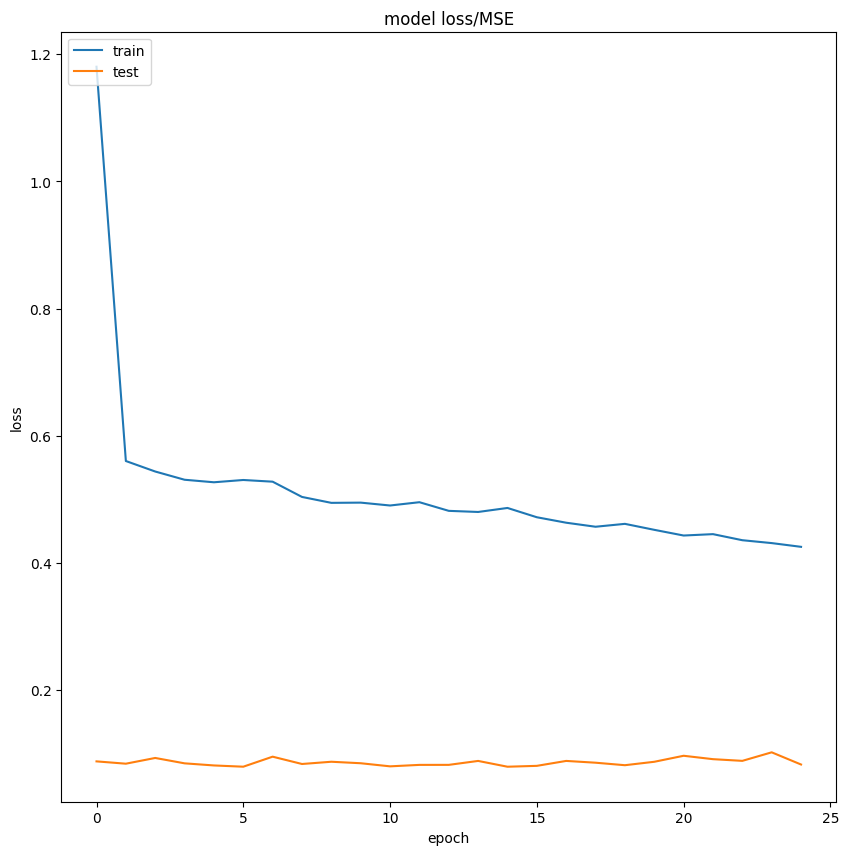

In [26]:
# summarize history for Loss/MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss/MSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss2.png")

129/129 - 1s - 4ms/step - loss: 0.8902 - mse: 0.8902

MSE: 0.8902442455291748
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


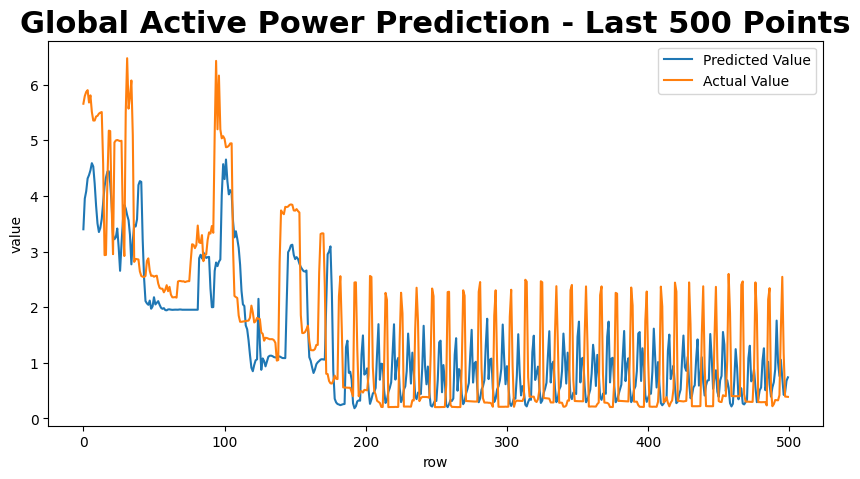

In [27]:
# show me how one or two of your different models perform 
# using the code from the "Validating our model" section above
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 500 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

**Q: How did your model changes affect performance on the validation data? Why do you think they were/were not effective? If you were trying to optimize for production, what would you try next?**

A: The loss has reduced for training and for validation, clearly indicating that adding a dense layer has improved performance of the model. For the production level solution , I will try to add more dense layers and atleast one more LSTM layer. Which will provide complexity to calculate the final GAP values, in addition to this one more feature will do good for the prediction - time of day will provide a better insight in the GAP values.

**Q: How did the models that you built in this assignment compare to the linear regression model from last week? Think about model performance and other IoT device considerations; Which model would you choose to use in an IoT system that predicts GAP for a single household with a 5-minute predictive horizon, and why?**

A: Comparing the model with the linear regression, model prepared last week,  neural network model , is a better fit for the GAP prediction. In the prediction as well, the model is able to predict the rigorous spikes and extremities to a good extent compared to the Linear regression model which was only predicting a single line. 